Step 4: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product

In [1]:
#fixed graph weights (same click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *

In [2]:
P1 = Product(0,[9,12,13,14.5],[ 1.,  4,  5., 6.5])
P2 = Product(1,[20,22.5,23,24.5],[ 4.,  6.5, 7., 8.5])
P3 = Product(2,[30,31.5,34,34.5],[ 6.,  7.5, 10., 10.5])
P4 = Product(3,[40,42.5,43,46.5],[ 8., 10.5, 11., 14.5])
P5 = Product(4,[50,51.5,53,54.5],[10., 11.5, 13., 14.5])

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce()
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

In [3]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100
binary_vector = np.array([127,0]) 
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.68774348 0.15970985 0.0667096  0.01311777]
 [0.93352969 0.59866598 0.49953848 0.226779  ]
 [0.99360299 0.96066996 0.69168258 0.59894813]
 [0.68979856 0.22545511 0.15820515 0.00308865]
 [0.97737589 0.89504351 0.69476869 0.40120915]]
_______________________________________________
Expected rewards per arm
[[ 1.36383917  1.29100006  0.67913402  0.16593438]
 [ 3.73090739  3.87254216  3.47795462  1.89327563]
 [17.71903004 21.34002145 20.25208642 18.6912073 ]
 [16.57267136  7.15992975  5.24123986  0.15199925]
 [ 9.44651393  9.8871203   8.78398734  5.56974364]]
_______________________________________________
Expected units sold per arm
[[1.98561885 1.99382132 2.01140209 1.90392076]
 [1.         1.         1.         1.        ]
 [3.00975307 2.99728634 2.9874783  2.99888536]
 [2.99818449 3.0202379  3.02704403 2.86930724]
 [1.         1.         1.         1.        ]]
_______________________________________________
Best confi

In [4]:
#Comparison between TS and UCB

n_arms = 4
num_users = 100
binary_vector = np.array([127,0]) 
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
gr_rewards_per_experiment = []
cr_rewards_per_experiment = []

ts_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha,fixed_weights,fixed_units)
    gr_learner = Greedy(n_arms=n_arms)
    ucb_learner = UCB(n_arms=n_arms)
    ts_learner = TS_poisson(n_arms=n_arms)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)

        pulled_arm = gr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)  

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)
    gr_rewards_per_experiment.append(gr_learner.collected_rewards)
    cr_rewards_per_experiment.append(cr_learner.collected_rewards)

    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

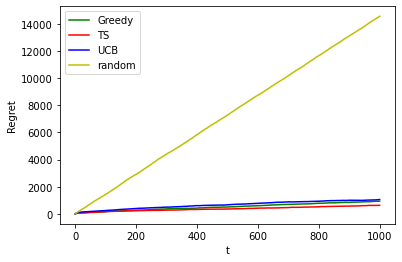

In [5]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - cr_rewards_per_experiment, axis=0)), 'y')
plt.legend(["Greedy","TS","UCB","random"])
plt.show()

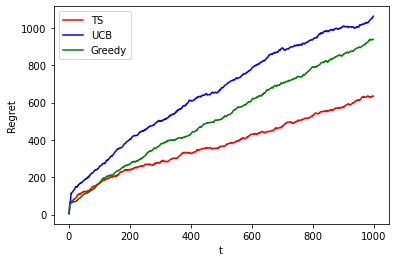

In [6]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.legend(["TS","UCB","Greedy"])
plt.show()

In [7]:
print("_______________________________________________")
print("TS Total collected reward")
print(np.sum(np.mean(ts_rewards_per_experiment,axis=0)))
print("UCB Total collected reward")
print(np.sum(np.mean(ucb_rewards_per_experiment,axis=0)))
print("_______________________________________________")

print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("UCB",np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))
print("UCB",np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))

_______________________________________________
TS Total collected reward
53055.72865457758
UCB Total collected reward
52627.424882982305
_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 1000 days and its standard deviation considering 10 experiments
TS 53055.728654577586 278.67746351478
UCB 52627.42488298231 635.118075817955
-----------------------------------------------
Total expected regret over 1000 days and its standard deviation considering 10 experiments
TS 634.6062540531836 278.6774635147786
UCB 1062.9100256484553 635.1180758179539
-----------------------------------------------
Average expected reward per round over 1000 days and its standard deviation between the rounds considering 10 experiments
TS 53.05572865457758 1.9189984828572357
UCB 52.627424882982304 2.11310446489777
-----------------------------------------------
Average expected regret per round over 1000 days

In [8]:
print("TS Pulls per arm")
for i in range(len(ts_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ts_pulls_per_arm_per_experiment[i])

TS Pulls per arm
_______________________________________________
[[930.  61.   8.   1.]
 [ 67. 907.  25.   1.]
 [  1. 925.  70.   4.]
 [995.   3.   1.   1.]
 [  1. 994.   3.   2.]]
_______________________________________________
[[930.  60.   6.   4.]
 [  2. 985.  11.   2.]
 [  2. 983.   1.  14.]
 [997.   1.   1.   1.]
 [  9. 979.  10.   2.]]
_______________________________________________
[[977.  13.   9.   1.]
 [ 79. 892.  25.   4.]
 [  1. 989.   4.   6.]
 [995.   2.   2.   1.]
 [  2. 996.   1.   1.]]
_______________________________________________
[[984.   1.  14.   1.]
 [ 31. 956.   9.   4.]
 [  1. 991.   7.   1.]
 [997.   1.   1.   1.]
 [  2. 990.   6.   2.]]
_______________________________________________
[[974.  17.   3.   6.]
 [  1. 972.  25.   2.]
 [  1.   1. 965.  33.]
 [994.   2.   3.   1.]
 [  1. 986.  12.   1.]]
_______________________________________________
[[996.   1.   2.   1.]
 [  2. 971.  25.   2.]
 [  1. 977.  13.   9.]
 [996.   2.   1.   1.]
 [  1. 989.   9.   1.]]

In [9]:
print("UCB Pulls per arm")
for i in range(len(ucb_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ucb_pulls_per_arm_per_experiment[i])

UCB Pulls per arm
_______________________________________________
[[788. 195.  15.   2.]
 [966.   2.  30.   2.]
 [ 39. 343.   2. 616.]
 [994.   2.   2.   2.]
 [167. 815.  16.   2.]]
_______________________________________________
[[969.  27.   2.   2.]
 [268. 659.  71.   2.]
 [ 17. 810. 129.  44.]
 [994.   2.   2.   2.]
 [192. 761.  45.   2.]]
_______________________________________________
[[984.   9.   5.   2.]
 [ 69. 914.  15.   2.]
 [  2. 994.   2.   2.]
 [988.   8.   2.   2.]
 [215. 729.  54.   2.]]
_______________________________________________
[[994.   2.   2.   2.]
 [186. 778.  34.   2.]
 [  2.   2. 981.  15.]
 [994.   2.   2.   2.]
 [282. 713.   3.   2.]]
_______________________________________________
[[735. 261.   2.   2.]
 [191. 724.  83.   2.]
 [  2. 994.   2.   2.]
 [985.  11.   2.   2.]
 [  2. 900.  81.  17.]]
_______________________________________________
[[967.  29.   2.   2.]
 [987.   2.   9.   2.]
 [ 13. 912.  57.  18.]
 [989.   2.   7.   2.]
 [ 85. 867.  46.   2.]

In [69]:
#Comparison between TS and UCB with respect to the number of users per round

n_arms = 4
num_users = 10
binary_vector = np.array([127,0]) 
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts_rewards_per_experiment_10 = []
ucb_rewards_per_experiment_10 = []

ts_rewards_per_experiment_100 = []
ucb_rewards_per_experiment_100 = []


ts_rewards_per_experiment_1000 = []
ucb_rewards_per_experiment_1000 = []


for e in range(n_experiments):

    env_10 = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_10 = UCB(n_arms=n_arms)
    ts_learner_10 = TS_poisson(n_arms=n_arms)

    env_100 = Environment(n_arms, E, margins_matrix, num_users*10, binary_vector, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_100 = UCB(n_arms=n_arms)
    ts_learner_100 = TS_poisson(n_arms=n_arms)

    env_1000 = Environment(n_arms, E, margins_matrix, num_users*100, binary_vector, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_1000 = UCB(n_arms=n_arms)
    ts_learner_1000 = TS_poisson(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner_10.pull_arm()
        reward = env_10.round(pulled_arm)
        ucb_learner_10.update(pulled_arm, reward)

        pulled_arm = ucb_learner_100.pull_arm()
        reward = env_100.round(pulled_arm)
        ucb_learner_100.update(pulled_arm, reward)

        pulled_arm = ucb_learner_1000.pull_arm()
        reward = env_1000.round(pulled_arm)
        ucb_learner_1000.update(pulled_arm, reward)
        
        pulled_arm = ts_learner_10.pull_arm(env_10.margins_matrix)
        reward = env_10.round(pulled_arm)
        ts_learner_10.update(pulled_arm, reward, env_10.clicks_current_day, env_10.purchases_current_day, env_10.daily_units)

        pulled_arm = ts_learner_100.pull_arm(env_100.margins_matrix)
        reward = env_100.round(pulled_arm)
        ts_learner_100.update(pulled_arm, reward, env_100.clicks_current_day, env_100.purchases_current_day,  env_100.daily_units)

        pulled_arm = ts_learner_1000.pull_arm(env_1000.margins_matrix)
        reward = env_1000.round(pulled_arm)
        ts_learner_1000.update(pulled_arm, reward, env_1000.clicks_current_day, env_1000.purchases_current_day,  env_1000.daily_units)

    ts_rewards_per_experiment_10.append(ts_learner_10.collected_rewards)
    ucb_rewards_per_experiment_10.append(ucb_learner_10.collected_rewards)

    
    ts_rewards_per_experiment_100.append(ts_learner_100.collected_rewards)
    ucb_rewards_per_experiment_100.append(ucb_learner_100.collected_rewards)

    
    ts_rewards_per_experiment_1000.append(ts_learner_1000.collected_rewards)
    ucb_rewards_per_experiment_1000.append(ucb_learner_1000.collected_rewards)


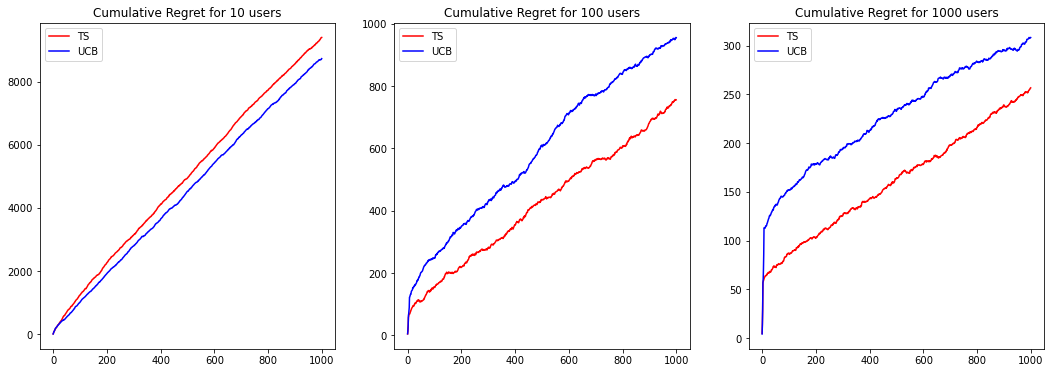

In [70]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_10, axis=0)), 'r')
ax[0].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_10, axis=0)), 'b')
ax[0].set_title("Cumulative Regret for 10 users")
ax[0].legend(["TS","UCB"])

ax[1].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_100, axis=0)), 'r')
ax[1].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_100, axis=0)), 'b')
ax[1].set_title("Cumulative Regret for 100 users")
ax[1].legend(["TS","UCB"])

ax[2].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_1000, axis=0)), 'r')
ax[2].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_1000, axis=0)), 'b')
ax[2].set_title("Cumulative Regret for 1000 users")
ax[2].legend(["TS","UCB"])

plt.show()